# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.548884,True,6.191588
1,0.266072,True,7.189133
2,-0.314336,True,3.239631
3,0.445868,False,1.293288
4,0.924347,False,2.331536
...,...,...,...
995,-0.974070,False,-3.710071
996,0.303959,False,0.624473
997,0.860809,True,7.784799
998,-1.798934,False,-2.973427


<Axes: xlabel='v0'>

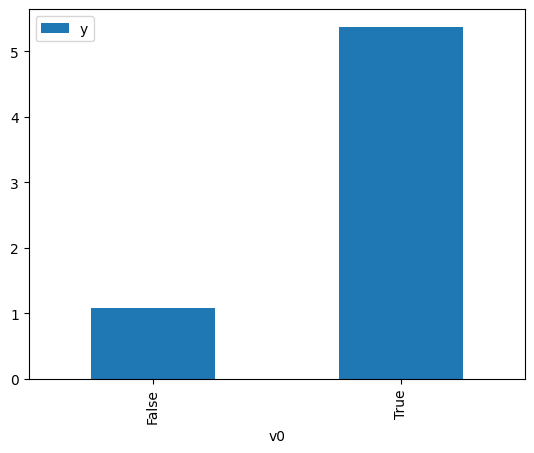

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

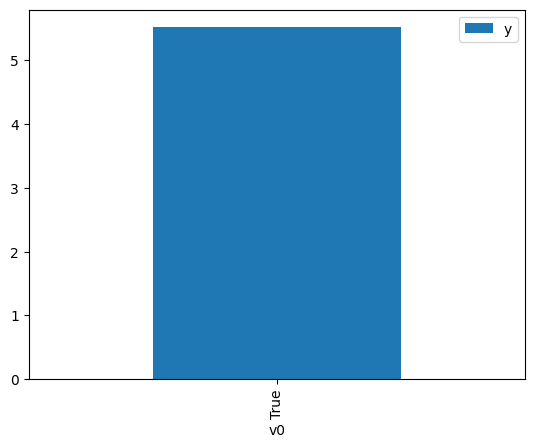

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.096528,False,0.183306,0.538606,1.856646
1,-0.734220,False,-3.570479,0.682607,1.464972
2,-0.378942,False,-0.118301,0.604761,1.653545
3,-0.482284,False,-0.733775,0.628169,1.591929
4,0.773438,False,3.004178,0.336510,2.971681
...,...,...,...,...,...
995,-0.157275,False,0.899083,0.553035,1.808205
996,3.361065,False,7.318491,0.040762,24.532810
997,2.495123,False,6.045135,0.088779,11.263919
998,-0.507111,False,0.616299,0.633708,1.578013


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.927786,True,7.179731,0.695675,1.437453
1,-0.815900,True,2.675049,0.300684,3.325755
2,-2.267000,True,1.037331,0.096694,10.341943
3,0.093084,True,6.131300,0.506739,1.973401
4,0.480552,True,5.849524,0.598264,1.671503
...,...,...,...,...,...
995,-0.314336,True,3.239631,0.410128,2.438266
996,1.397253,True,8.301519,0.781877,1.278974
997,-0.941046,True,4.565827,0.276086,3.622066
998,-0.174306,True,4.539346,0.442935,2.257667


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.961
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                          1.239e+04
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                        0.00
Time:                        17:29:56   Log-Likelihood:                         -1433.3
No. Observations:                1000   AIC:                                      2871.
Df Residuals:                     998   BIC:                                      2880.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1684      0.033     64.763      0.000       2.103       2.234
x2             4.9511      0.049    101.263      0.000       4.855       5.047
==============================================================================
Omnibus:                        0.103   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.950   Jarque-Bera (JB):                0.043
Skew:                          -0.001   Prob(JB):                        0.979
Kurtosis:                       3.032   Cond. No.                         1.84
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""